# Neural Receiver for OFDM SIMO Systems

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [3]:
############################################
## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "C" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 20.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 5000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
results_filename = "neural_receiver_results" # Location to save the results

In [4]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter

In [5]:
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

In [6]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

In [7]:
ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

## Neural Receiver <a class="anchor" id="Neural-Receiver"></a>

In [8]:
class ResidualBlock(Layer):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.

    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer

    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):
    r"""
    Keras layer implementing a residual convolutional neural receiver.

    This neural receiver is fed with the post-DFT received samples, forming a resource grid of size num_of_symbols x fft_size, and computes LLRs on the transmitted coded bits.
    These LLRs can then be fed to an outer decoder to reconstruct the information bits.

    As the neural receiver is fed with the entire resource grid, including the guard bands and pilots, it also computes LLRs for these resource elements.
    They must be discarded to only keep the LLRs corresponding to the data-carrying resource elements.

    Input
    ------
    y : [batch size, num rx antenna, num ofdm symbols, num subcarriers], tf.complex
        Received post-DFT samples.

    no : [batch size], tf.float32
        Noise variance. At training, a different noise variance value is sampled for each batch example.

    Output
    -------
    : [batch size, num ofdm symbols, num subcarriers, num_bits_per_symbol]
        LLRs on the transmitted bits.
        LLRs computed for resource elements not carrying data (pilots, guard bands...) must be discarded.
    """

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        y, no = inputs

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

## End-to-end System <a class="anchor" id="End-to-end-System"></a>

In [9]:
## Transmitter
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

In [10]:
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)


## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel([x_rg, no_])
print("y shape: ", y.shape)

######################################
## Receiver       
# The neural receiver computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
y shape:  (64, 1, 2, 14, 128)
llr shape:  (64, 14, 128, 2)
Post RG-demapper LLRs:  (64, 1, 1, 2784)


In [11]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: -5.91E-01 bit


## End-to-end System as a Keras Model <a class="anchor" id="End-to-end-System-as-a-Keras-Model"></a>

In [12]:
class E2ESystem(Model):
    r"""
    Keras model that implements the end-to-end systems.

    As the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver) share most of
    the link components (transmitter, channel model, outer code...), they are implemented using the same Keras model.

    When instantiating the Keras model, the parameter ``system`` is used to specify the system to setup,
    and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated.
    The ``training`` parameter is only relevant when the neural

    At each call of this model:
    * A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
    * A batch of channel realizations is randomly sampled and applied to the channel inputs
    * The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
      Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends
      on the specified ``system`` parameter.
    * If not training, the outer decoder is applied to reconstruct the information bits
    * If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits

    Parameters
    -----------
    system : str
        Specify the receiver to use. Should be one of 'baseline-perfect-csi', 'baseline-ls-estimation' or 'neural-receiver'

    training : bool
        Set to `True` if the system is instantiated to be trained. Set to `False` otherwise. Defaults to `False`.
        If the system is instantiated to be trained, the outer encoder and decoder are not instantiated as they are not required for training.
        This significantly reduces the computational complexity of training.
        If training, the bit-metric decoding (BMD) rate is computed from the transmitted bits and the LLRs. The BMD rate is known to be
        an achievable information rate for BICM systems, and therefore training of the neural receiver aims at maximizing this rate.

    Input
    ------
    batch_size : int
        Batch size

    no : scalar or [batch_size], tf.float
        Noise variance.
        At training, a different noise variance should be sampled for each batch example.

    Output
    -------
    If ``training`` is set to `True`, then the output is a single scalar, which is an estimation of the BMD rate computed over the batch. It
    should be used as objective for training.
    If ``training`` is set to `False`, the transmitted information bits and their reconstruction on the receiver side are returned to
    compute the block/bit error rate.
    """

    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of `system`
        if "baseline" in system:
            if system == 'baseline-perfect-csi': # Perfect CSI
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation': # LS estimation
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            # Components required by both baselines
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db, epsilon=0.0):
        
        # Verifica se `ebno_db` é escalar e ajusta para tensor de tamanho `batch_size`
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)

        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])

        y_original = tf.identity(y)

        # FGSM perturbação adversarial
        if epsilon > 0:
            with tf.GradientTape() as tape:
                tape.watch(y)
                if "baseline" in self._system:
                    if self._system == 'baseline-perfect-csi':
                        h_hat = self._removed_null_subc(h)
                        err_var = 0.0
                    elif self._system == 'baseline-ls-estimation':
                        h_hat, err_var = self._ls_est([y, no])
                    x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
                    no_eff_ = expand_to_rank(no_eff, tf.rank(x_hat))
                    llr = self._demapper([x_hat, no_eff_])
                elif self._system == "neural-receiver":
                    y_temp = tf.squeeze(y, axis=1)  # Certifique-se de criar uma cópia temporária
                    llr = self._neural_receiver([y_temp, no])

            # Calcula gradiente para gerar perturbação adversarial
            grad = tape.gradient(llr, y)
            if grad is not None:  # Garante que o gradiente não seja None
                perturbation = epsilon * tf.sign(grad)
                y = y + perturbation
            else:
                raise ValueError("O gradiente não pôde ser calculado.")
            
        noise = y - y_original
        noise_power = tf.reduce_mean(tf.square(noise))  # Potência média do ruído   
        ######################################
        ## Receiver
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h)
                err_var = 0.0
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no])
            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
            no_eff_ = expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_])
        elif self._system == "neural-receiver":
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1)
            llr = self._rg_demapper(llr)
            llr = tf.reshape(llr, [batch_size, 1, 1, n])

        if self._training:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce / tf.math.log(2.0)
            return rate
        else:
            b_hat = self._decoder(llr)
            return b, b_hat, noise_power

## Evaluation of the Baselines <a class="anchor" id="Evaluation-of-the-Baselines"></a>

In [13]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [14]:
import tensorflow as tf
import time

def eval_bler(model, ebno_dbs, batch_size, num_target_block_errors, max_mc_iter, epsilon=0.0):
    # Prepare table for logging results
    blers = []  # Lista para armazenar os valores de BLER
    noise_powers = []  # Lista para armazenar os valores de potência média do ruído

    print("EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status    | avg noise power")
    print("-" * 150)

    for ebno_db in ebno_dbs:
        start_time = time.time()
        num_bit_errors = 0
        num_block_errors = 0
        num_bits_total = 0
        num_blocks_total = 0
        total_noise_power = 0.0  # Acumulador da potência do ruído

        status = "reached max iter"
        for _ in range(max_mc_iter):
            # Converte batch_size e ebno_db para tensores
            batch_size_tensor = tf.constant(batch_size, dtype=tf.int32)
            ebno_db_tensor = tf.constant(ebno_db, dtype=tf.float32)

            # Simulate a batch
            b, b_hat, noise_power = model(batch_size_tensor, ebno_db_tensor, epsilon=epsilon)
            bit_errors = tf.reduce_sum(tf.cast(b != b_hat, tf.int32))
            block_errors = tf.reduce_sum(tf.cast(tf.reduce_any(b != b_hat, axis=-1), tf.int32))

            num_bit_errors += int(bit_errors)
            num_block_errors += int(block_errors)
            num_bits_total += tf.size(b).numpy()
            num_blocks_total += batch_size
            total_noise_power += float(noise_power)  # Acumula a potência do ruído

            # Stop if target block errors are reached
            if num_block_errors >= num_target_block_errors:
                status = "reached target block errors"
                break

        # Calculate BER, BLER, and average noise power
        ber = num_bit_errors / num_bits_total
        bler = num_block_errors / num_blocks_total
        avg_noise_power = total_noise_power / num_blocks_total if num_blocks_total > 0 else 0.0

        # Runtime for this EbNo
        runtime = time.time() - start_time

        # Append BLER and noise power results
        blers.append(bler)
        noise_powers.append(avg_noise_power)
        
        # Print the current result
        print(f"{ebno_db:10.1f} | {ber:10.4e} | {bler:10.4e} | {num_bit_errors:13d} | {num_bits_total:11d} | {num_block_errors:13d} | {num_blocks_total:12d} | {runtime:10.1f} | {status} | {avg_noise_power:10.4e}")

        # Stop simulation early if BER and BLER are zero
        if ber == 0 and bler == 0:
            print(f"\nSimulation stopped as no error occurred @ EbNo = {ebno_db} dB.\n")
            break

    # Return BLERs and average noise powers as separate lists
    return blers, noise_powers

In [15]:
# Dicionário para armazenar BLER
BLER = {}

# Simulação para diferentes configurações
model = E2ESystem('baseline-perfect-csi')
bler_baseline_perfect, _ = eval_bler(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-perfect-csi'] = bler_baseline_perfect
model = E2ESystem('baseline-ls-estimation')
bler_baseline_ls, _ = eval_bler(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-ls-estimation'] = bler_baseline_ls



EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status    | avg noise power
------------------------------------------------------------------------------------------------------------------------------------------------------


/home/gustavo/Trab_Trans_Dig/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


      -5.0 | 2.5209e-01 | 1.0000e+00 |         44916 |      178176 |           128 |          128 |        4.5 | reached target block errors | 0.0000e+00
      -4.5 | 2.3712e-01 | 1.0000e+00 |         42249 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -4.0 | 2.1769e-01 | 1.0000e+00 |         38787 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -3.5 | 1.9162e-01 | 1.0000e+00 |         34142 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -3.0 | 1.5846e-01 | 1.0000e+00 |         28233 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -2.5 | 1.0702e-01 | 9.9219e-01 |         19068 |      178176 |           127 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -2.0 | 1.6891e-02 | 5.1172e-01 |          6019 |      356352 |        

## Training the Neural Receiver <a class="anchor" id="Training-the-Neural-Receiver"></a>

In [16]:
# The end-to-end system equipped with the neural receiver is instantiated for training.
# When called, it therefore returns the estimated BMD rate
model = E2ESystem('neural-receiver', training=True)

# Sampling a batch of SNRs
ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
# Forward pass
with tf.GradientTape() as tape:
    rate = model(16, ebno_db)
    # Tensorflow optimizers only know how to minimize loss function.
    # Therefore, a loss function is defined as the additive inverse of the BMD rate
    loss = -rate

In [17]:
optimizer = tf.keras.optimizers.Adam()

# Computing and applying gradients
weights = model.trainable_weights
grads = tape.gradient(loss, weights)
optimizer.apply_gradients(zip(grads, weights))

I0000 00:00:1734400929.094554 3545000 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [18]:
training = False # Change to True to train your own model
if training:
    model = E2ESystem('neural-receiver', training=True)
    
    optimizer = tf.keras.optimizers.Adam()
    
    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(16, ebno_db)
            # Tensorflow optimizers only know how to minimize loss function.
            # Therefore, a loss function is defined as the additive inverse of the BMD rate
            loss = -rate
        # Computing and applying gradients
        weights = model.trainable_weights
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        # Periodically printing the progress
        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')
    
    # Save the weights in a file
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

## Evaluation of the Neural Receiver <a class="anchor" id="Evaluation-of-the-Neural-Receiver"></a>

In [19]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

# Evaluations
bler_neural_receiver, _ = eval_bler(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver'] = bler_neural_receiver

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status    | avg noise power
------------------------------------------------------------------------------------------------------------------------------------------------------
      -5.0 | 2.6101e-01 | 1.0000e+00 |         46506 |      178176 |           128 |          128 |        0.3 | reached target block errors | 0.0000e+00
      -4.5 | 2.4269e-01 | 1.0000e+00 |         43242 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -4.0 | 2.2638e-01 | 1.0000e+00 |         40336 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -3.5 | 2.0496e-01 | 1.0000e+00 |         36519 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -3.0 | 1.7610e-01 | 1.0000e+00 |         31376 |      178176 |           128 |         

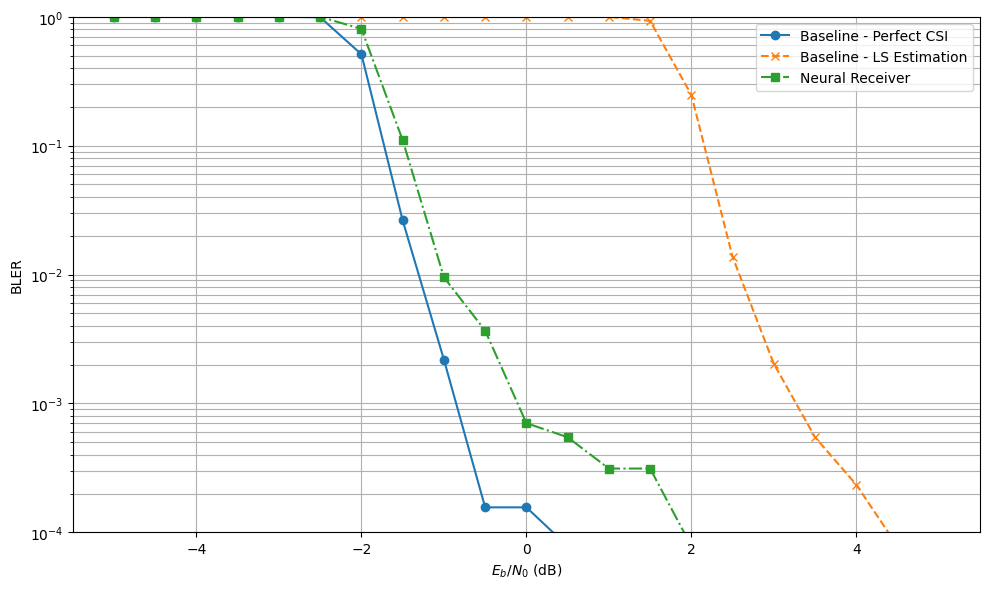

In [20]:
# Ajustando ebno_dbs para corresponder ao tamanho de BLER
adjusted_ebno_dbs = ebno_dbs[:len(BLER['baseline-perfect-csi'])]

plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(adjusted_ebno_dbs, BLER['baseline-perfect-csi'], 'o-', c='C0', label='Baseline - Perfect CSI')
# Baseline - LS Estimation
adjusted_ebno_dbs_ls = ebno_dbs[:len(BLER['baseline-ls-estimation'])]
plt.semilogy(adjusted_ebno_dbs_ls, BLER['baseline-ls-estimation'], 'x--', c='C1', label='Baseline - LS Estimation')
# Neural receiver
adjusted_ebno_dbs_neural = ebno_dbs[:len(BLER['neural-receiver'])]
plt.semilogy(adjusted_ebno_dbs_neural, BLER['neural-receiver'], 's-.', c='C2', label='Neural Receiver')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()


## Pre-computed Results <a class="anchor" id="Pre-computed-Results"></a>

In [21]:
pre_computed_results = "{'baseline-perfect-csi': [1.0, 1.0, 1.0, 1.0, 1.0, 0.9916930379746836, 0.5367080479452054, 0.0285078125, 0.0017890625, 0.0006171875, 0.0002265625, 9.375e-05, 2.34375e-05, 7.8125e-06, 1.5625e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'baseline-ls-estimation': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998022151898734, 0.9199448529411764, 0.25374190938511326, 0.0110234375, 0.002078125, 0.0008359375, 0.0004375, 0.000171875, 9.375e-05, 4.6875e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'neural-receiver': [1.0, 1.0, 1.0, 1.0, 1.0, 0.9984177215189873, 0.7505952380952381, 0.10016025641025642, 0.00740625, 0.0021640625, 0.000984375, 0.0003671875, 0.000203125, 0.0001484375, 3.125e-05, 2.34375e-05, 7.8125e-06, 7.8125e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}"
BLER = eval(pre_computed_results)

---

## ADV EVAL

In [22]:
epsilon_list = [0.0, 0.1, 0.4, 0.5, 0.7, 0.9]

In [23]:
model = E2ESystem('baseline-ls-estimation')

# Dicionário para armazenar os resultados de BLER para cada epsilon
fgsm_bler_ls_estimation = {}
noise_comparison_ls_estimation = {}

# Itera sobre cada valor de epsilon e calcula o BLER
for epsilon in epsilon_list:
    print(f"\nCalculando ls-estimation BLER para epsilon = {epsilon:.2f}")
    bler_baseline_ls, noise_powers_baseline_ls = eval_bler(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100, epsilon=epsilon)
    # Salva os resultados no dicionário
    noise_comparison_ls_estimation[epsilon] = noise_powers_baseline_ls
    fgsm_bler_ls_estimation[epsilon] = bler_baseline_ls



Calculando ls-estimation BLER para epsilon = 0.00
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status    | avg noise power
------------------------------------------------------------------------------------------------------------------------------------------------------
      -5.0 | 3.8929e-01 | 1.0000e+00 |         69363 |      178176 |           128 |          128 |        1.5 | reached target block errors | 0.0000e+00
      -4.5 | 3.7561e-01 | 1.0000e+00 |         66925 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -4.0 | 3.7024e-01 | 1.0000e+00 |         65967 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -3.5 | 3.5531e-01 | 1.0000e+00 |         63308 |      178176 |           128 |          128 |        0.0 | reached target block errors | 0.0000e+00
      -3.0 | 3.4332e-01 | 1.0000e+00 |    

In [24]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)


# Dicionário para armazenar os resultados de BLER para cada epsilon
fgsm_bler_neural_receiver = {}
noise_comparison_neural_receiver = {}
# Itera sobre cada valor de epsilon e calcula o BLER
for epsilon in epsilon_list:
    print(f"\nCalculando neural-receiver BLER para epsilon = {epsilon:.2f}")
    bler_neural_receiver, noise_powers_neural_receiver = eval_bler(
        model, ebno_dbs,
        batch_size=128,
        num_target_block_errors=100,
        max_mc_iter=100,
        epsilon=epsilon  # Passa o valor de epsilon
    )
    # Salva os resultados no dicionário
    noise_comparison_neural_receiver[epsilon] = noise_powers_neural_receiver
    fgsm_bler_neural_receiver[epsilon] = bler_neural_receiver



Calculando neural-receiver BLER para epsilon = 0.00
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status    | avg noise power
------------------------------------------------------------------------------------------------------------------------------------------------------
      -5.0 | 2.5975e-01 | 1.0000e+00 |         46281 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -4.5 | 2.4347e-01 | 1.0000e+00 |         43381 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -4.0 | 2.2358e-01 | 1.0000e+00 |         39836 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -3.5 | 2.0415e-01 | 1.0000e+00 |         36375 |      178176 |           128 |          128 |        0.1 | reached target block errors | 0.0000e+00
      -3.0 | 1.7841e-01 | 1.0000e+00 |  

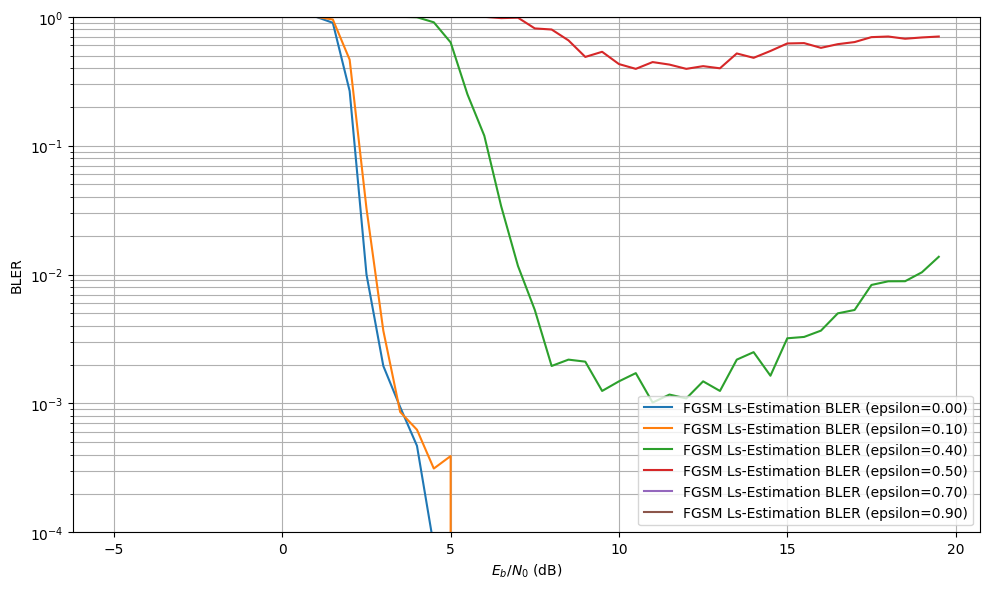

In [25]:
plt.figure(figsize=(10, 6))

for epsilon in epsilon_list:  # Iterate directly over values in epsilon_list
    plt.semilogy(
        ebno_dbs[:len(fgsm_bler_ls_estimation[epsilon])], 
        fgsm_bler_ls_estimation[epsilon], 
        label=f"FGSM Ls-Estimation BLER (epsilon={epsilon:.2f})", 
        linestyle='-'
    )

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()


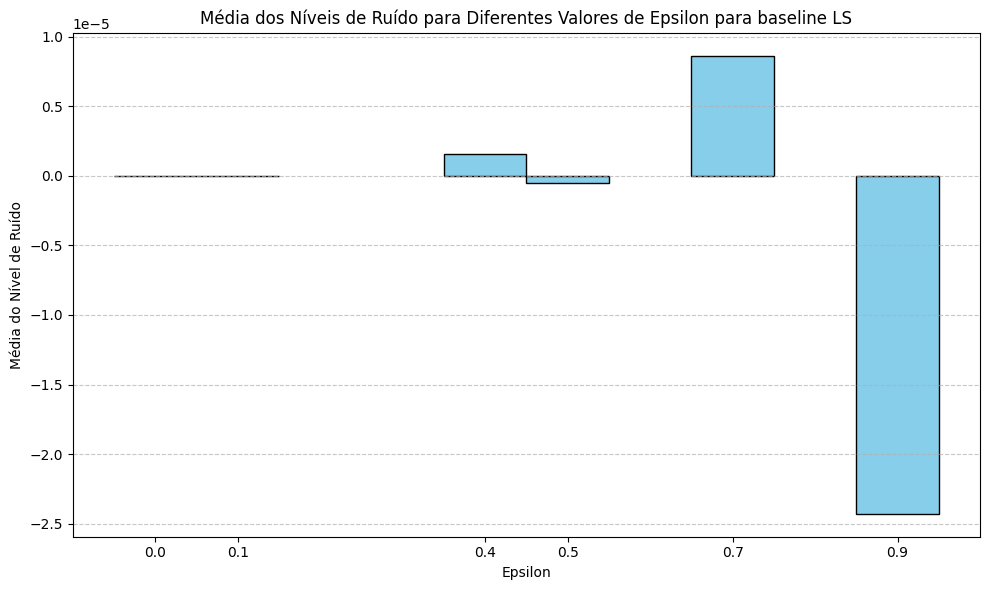

In [27]:
# INCOMPLETO, RESULTADOS INCONCLUSIVOS
"""import matplotlib.pyplot as plt
import numpy as np

# Cálculo das médias para cada epsilon
noise_means = {epsilon: np.mean(noise_powers) for epsilon, noise_powers in noise_comparison_ls_estimation.items()}

# Ajuste para largura das barras
plt.figure(figsize=(10, 6))
plt.bar(noise_means.keys(), noise_means.values(), color='skyblue', edgecolor='black', width=0.1)

# Configurações do gráfico
plt.title("Média dos Níveis de Ruído para Diferentes Valores de Epsilon para baseline LS")
plt.xlabel("Epsilon")
plt.ylabel("Média do Nível de Ruído")
plt.xticks(list(noise_means.keys()))  # Garante que os ticks no eixo X correspondam a cada epsilon
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()"""



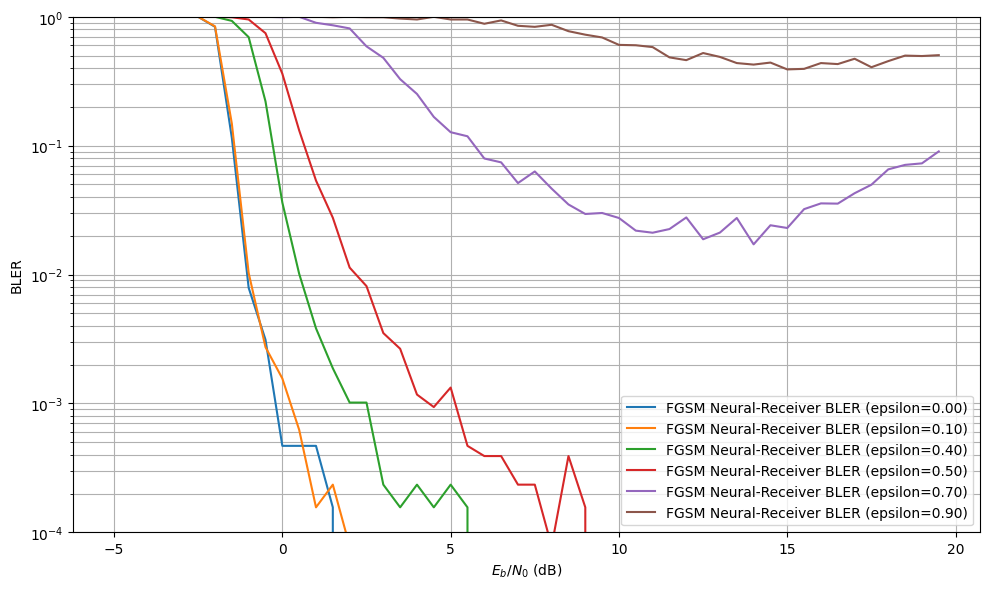

In [28]:
plt.figure(figsize=(10, 6))

for epsilon in epsilon_list:
    plt.semilogy(
        ebno_dbs[:len(fgsm_bler_neural_receiver[epsilon])], 
        fgsm_bler_neural_receiver[epsilon], 
        label=f"FGSM Neural-Receiver BLER (epsilon={epsilon:.2f})", 
        linestyle='-'
    )

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()


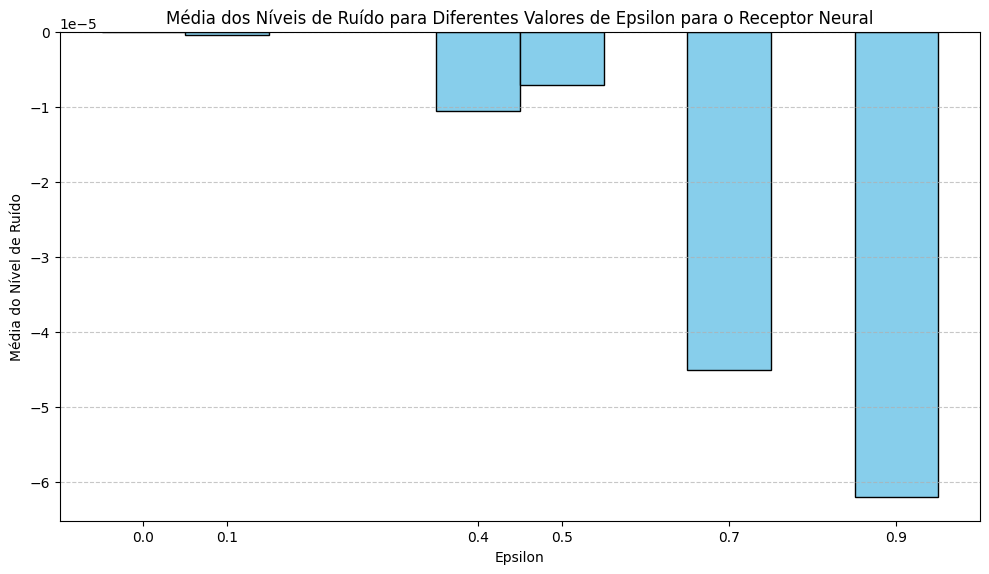

In [29]:
# INCOMPLETO, RESULTADOS INCONCLUSIVOS
"""import matplotlib.pyplot as plt
import numpy as np

# Cálculo das médias para cada epsilon
noise_means = {epsilon: np.mean(noise_powers) for epsilon, noise_powers in noise_comparison_neural_receiver.items()}

# Ajuste para largura das barras
plt.figure(figsize=(10, 6))
plt.bar(noise_means.keys(), noise_means.values(), color='skyblue', edgecolor='black', width=0.1)

# Configurações do gráfico
plt.title("Média dos Níveis de Ruído para Diferentes Valores de Epsilon para o Receptor Neural")
plt.xlabel("Epsilon")
plt.ylabel("Média do Nível de Ruído")
plt.xticks(list(noise_means.keys()))  # Garante que os ticks no eixo X correspondam a cada epsilon
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()"""



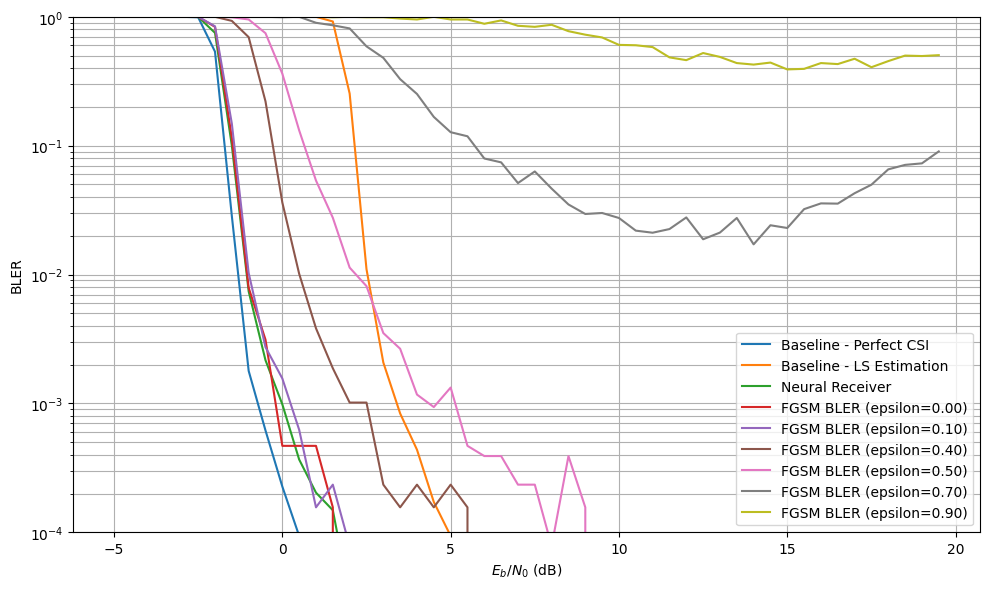

In [30]:
plt.figure(figsize=(10, 6))

adjusted_ebno_dbs = ebno_dbs[:len(BLER['baseline-perfect-csi'])]
# Baseline - Perfect CSI
plt.semilogy(
    adjusted_ebno_dbs, 
    BLER['baseline-perfect-csi'], 
    label='Baseline - Perfect CSI'
)

# Baseline - LS Estimation
adjusted_ebno_dbs_ls = ebno_dbs[:len(BLER['baseline-ls-estimation'])]
plt.semilogy(
    adjusted_ebno_dbs_ls, 
    BLER['baseline-ls-estimation'],  
    label='Baseline - LS Estimation'
)

# Neural Receiver
adjusted_ebno_dbs_neural = ebno_dbs[:len(BLER['neural-receiver'])]
plt.semilogy(
    adjusted_ebno_dbs_neural, 
    BLER['neural-receiver'], 
    label='Neural Receiver'
)


for i, epsilon in enumerate(epsilon_list):
    if epsilon in fgsm_bler_neural_receiver:
        plt.semilogy(
            ebno_dbs[:len(fgsm_bler_neural_receiver[epsilon])], 
            fgsm_bler_neural_receiver[epsilon], 
            label=f"FGSM BLER (epsilon={epsilon:.2f})", 
            linestyle='-'
        )

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
eb = 1  # Energia por bit fixa

# Calcular N0 para cada SNR
ebno_linear = 10 ** (ebno_dbs / 10)  # Converter SNR de dB para escala linear
n0_values = eb / ebno_linear  # N0 = Eb / SNR

# Cores para cada epsilon com uma paleta aprimorada
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plotar comparações
plt.figure(figsize=(10, 6))
plt.plot(ebno_dbs, n0_values, label='$N_0$ (AWGN)', linestyle='-', marker='o', color='black', linewidth=2)

for epsilon, color in zip(epsilon_list, colors):
    fgsm_power = epsilon ** 2  # Potência do ruído adversarial FGSM
    plt.axhline(y=fgsm_power, color=color, linestyle='--', linewidth=2, label=f'Potência do FGSM (ε={epsilon})')

# Configurações do gráfico
plt.title('Comparação entre $N_0$ e Potência do Ruído FGSM')
plt.xlabel('SNR (dB)')
plt.ylabel('Potência do Ruído')
plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.legend()
plt.grid()
plt.show()

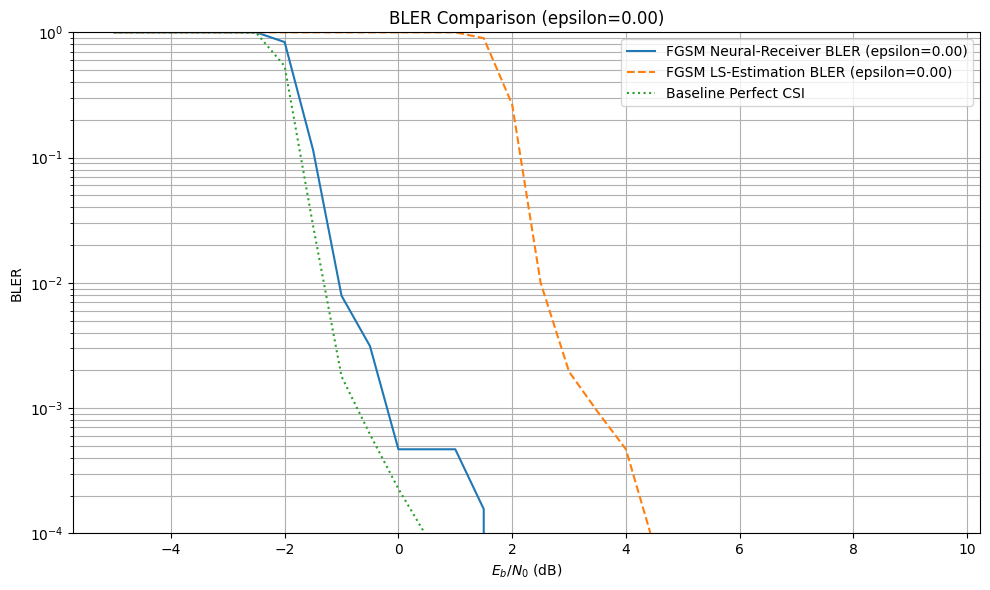

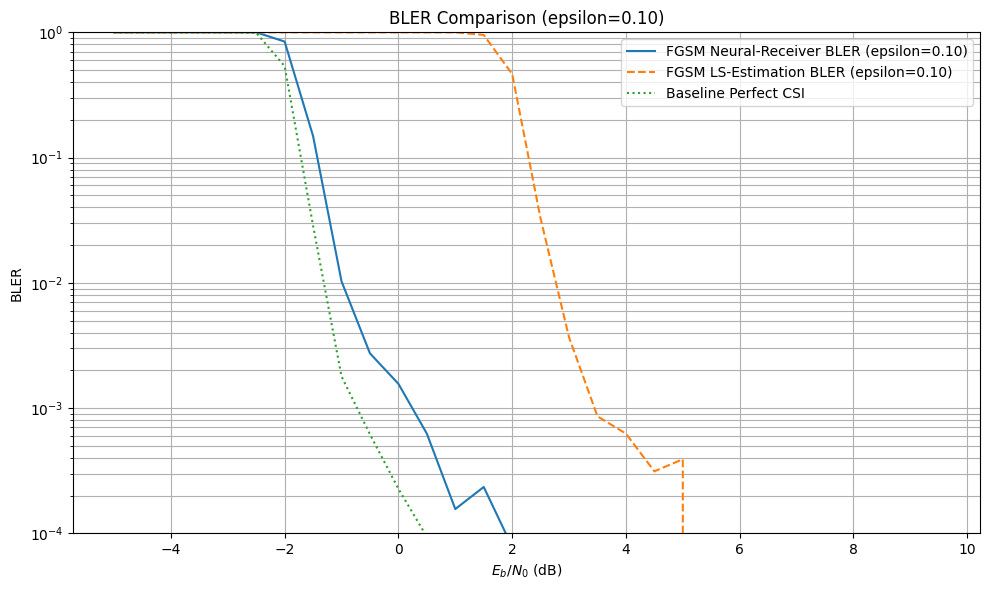

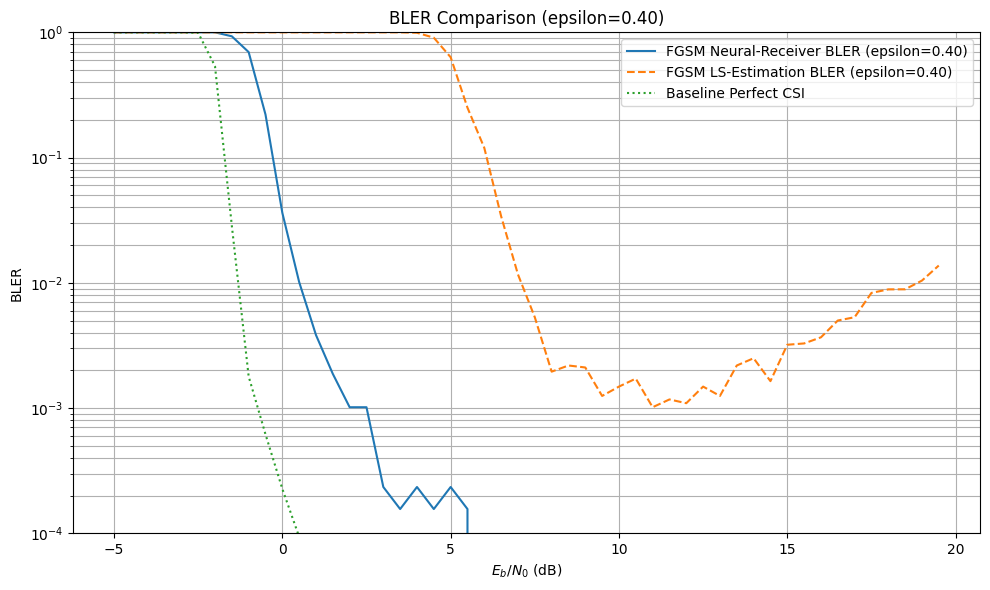

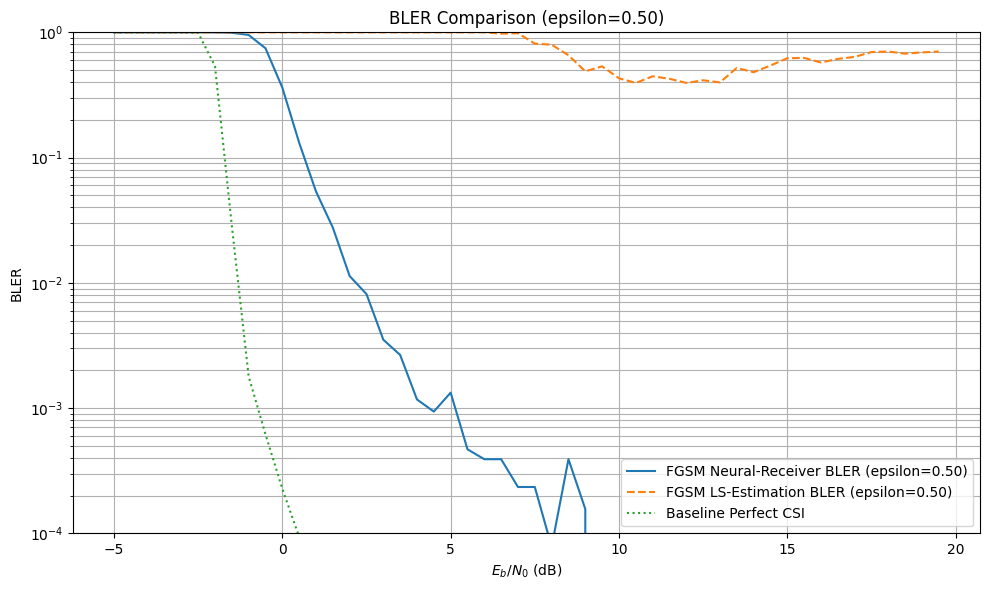

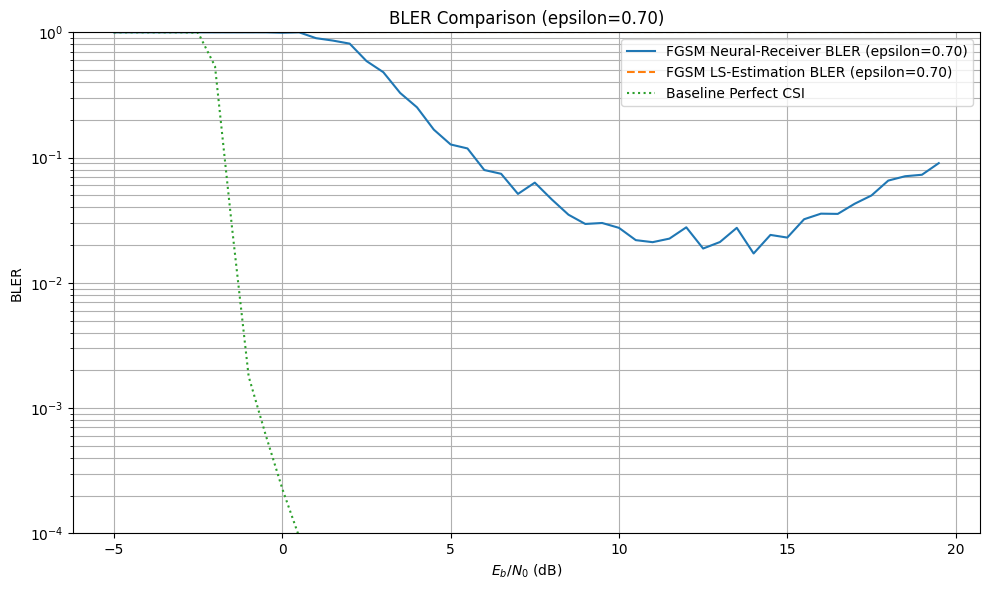

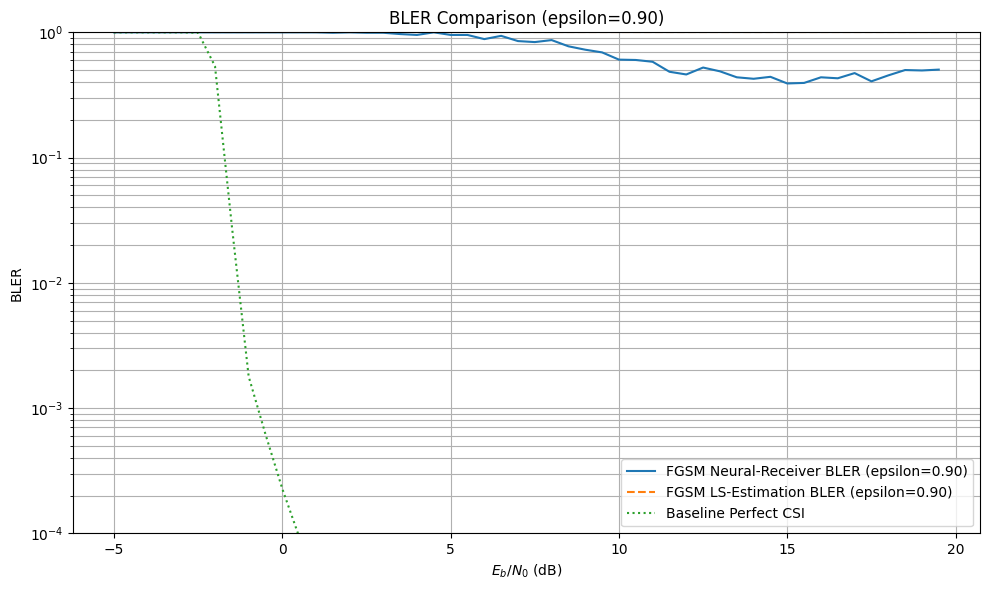

In [31]:
import matplotlib.pyplot as plt

# Iterar sobre cada epsilon na lista
for epsilon in epsilon_list:
    plt.figure(figsize=(10, 6))

    # Plotar o FGSM Neural Receiver BLER
    plt.semilogy(
        ebno_dbs[:len(fgsm_bler_neural_receiver[epsilon])], 
        fgsm_bler_neural_receiver[epsilon], 
        label=f"FGSM Neural-Receiver BLER (epsilon={epsilon:.2f})", 
        linestyle='-'
    )
    
    # Plotar o FGSM LS Estimation BLER
    plt.semilogy(
        ebno_dbs[:len(fgsm_bler_ls_estimation[epsilon])], 
        fgsm_bler_ls_estimation[epsilon], 
        label=f"FGSM LS-Estimation BLER (epsilon={epsilon:.2f})", 
        linestyle='--'
    )

    # Plotar o BLER baseline-perfect-csi
    plt.semilogy(
        ebno_dbs[:len(BLER['baseline-perfect-csi'])], 
        BLER['baseline-perfect-csi'], 
        label="Baseline Perfect CSI", 
        linestyle=':'
    )
    
    # Configuração dos eixos e legendas
    plt.xlabel(r"$E_b/N_0$ (dB)")
    plt.ylabel("BLER")
    plt.title(f"BLER Comparison (epsilon={epsilon:.2f})")
    plt.grid(which="both")
    plt.ylim((1e-4, 1.0))
    plt.legend()
    plt.tight_layout()
    plt.show()
